In [1]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from astropy.table import Table
import os
from scipy.optimize import curve_fit
import fnmatch
import clmm.polaraveraging as pa
import mock_data as mock
import pickle 

we import new core modules

In [2]:
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import stacking as stack
import modelling as model

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/register.py:138: UserWarning: Site determined from env variable DESC_GCR_SITE = in2p3, which differs from node name dc35216a8507
  self._DESC_SITE_ENV, site_from_env, site_from_socket


In [18]:
np.random.seed(11)

we define the `Stacking` object `shear` by definning a background cosmology, a gien range of radial axis and the number of bins for the binned stacked shear profile.

In [19]:
cosmo = FlatLambdaCDM(H0=71 * u.km / u.s / u.Mpc, Tcmb0=0 * u.K, Om0=0.265, Ob0 = 0.0448, Neff = 3.04, m_nu=None)
shear = stack.Stacking( r_low = 0.2,  r_up = 5, n_bins = 15, cosmo = cosmo)

we now define the type of desired profile : tangential reduced shear of Excess surface density for the stacking procedure by modifying the atribute. We use the method `Type` from the class to select DeltaSigma of reduced tangential shear.

In [20]:
is_deltasigma = True

In [21]:
shear.SelectType(is_deltasigma = True)

We now define some redshift interval and input mass interval to select GalaxyCluster object in preselected galaxy catalogs from `cosmoDC2`

In [23]:
z_bin = [0.4,0.5]
m_bin = [1*10**14, 1.1*10**14] #Solar Mass
m_bin = np.array(m_bin)
n_catalogs = 50
ngals = 20000

In [24]:
cluster_m = (m_bin[1] - m_bin[0])*np.random.random(n_catalogs) + m_bin[0]
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]

We add each galaxy catalogs that correponds to binning criteria to the `shear` object through the `Add(self,'file_name')` method.

In [25]:
for i in range(n_catalogs):
    #generate random background galaxy catalogs using CLMM mock data
    c = model.concentration(cluster_m[i], cluster_z[i])
    data = mock.generate_galaxy_catalog(cluster_m[i]*cosmo.h, cluster_z[i], c, cosmo,  200,'chang13', zsrc_min = cluster_z[i] + 0.1 ,shapenoise = 0.01,ngals=ngals)
    cl = clmm.GalaxyCluster('cluster', 0, 0,
                                  cluster_z[i], data)
    shear.AddCatalog(cl, Shapenoise = False)

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


The attribute `profile` of `shear` object is filled using the method `MakeShearProfile`, where the stacking method can be choosen as `'classical'` or weighted `'error weighted'`. The number of selected galaxy catalogs is visible with `n_stacked_gt` attribute

In [26]:
shear.MakeShearProfile('error weighted')
print(f'we selected {shear.n_stacked_gt} clusters')

we selected 50 clusters


The `profile` attribute is an astropy table containing the binned profile `gt` the error `gt_err` along the radial axis `radius`

### Visualization of the results

we visualize the reduced tangential stacked shear and we calculate the predicted reduced shear when using the average innput mass of selected clusters.

In [27]:
profile = shear.profile

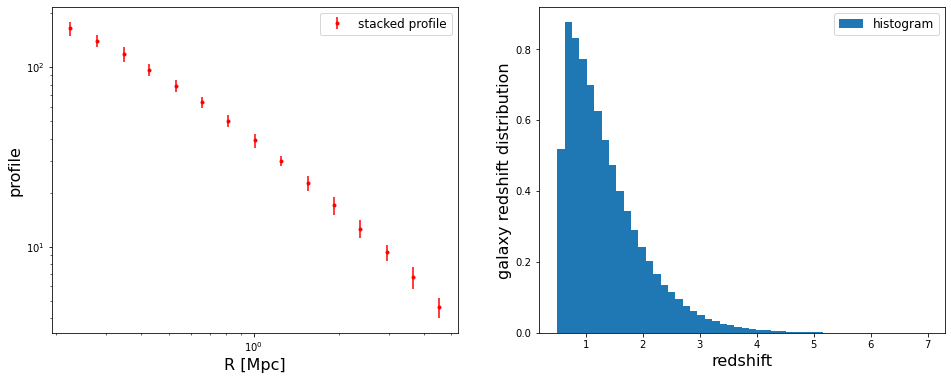

In [28]:
#plt.errorbar(profile_classical['radius'], profile_classical['gt'], profile_classical['gt_err'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].errorbar(profile['radius'], profile['gt'],profile['gt_err'], color='red', label='stacked profile', fmt='.')
axes[0].set_xlabel('R [Mpc]', fontsize=16)
axes[0].set_ylabel('profile', fontsize=16)
axes[0].legend(fontsize=12)
axes[0].semilogx()
axes[0].semilogy()
axes[1].hist(shear.z_galaxy_list, bins = 50,label='histogram', density = True)
axes[1].set_xlabel('redshift', fontsize=16)
axes[1].set_ylabel('galaxy redshift distribution', fontsize=16)
axes[1].legend(fontsize=12)

### Defining a model and a fitting procedure

In [29]:
def model_data(r,logm):
    if is_deltasigma == False:
        return model.predict_reduced_tangential_shear_z_distrib(r, logm, shear.average_z, shear.z_galaxy_list, cosmo)

    else:
        return model.predict_excess_surface_density(r, logm, shear.average_z, shear.z_galaxy_list, cosmo)

### Fitting a halo mass

In [30]:
param_p0 = [14.]
param_bounds = ([13. ], [16.])
logm_fit, cov_logm_fit = curve_fit(model_data, profile['radius'], profile['gt'], sigma = profile['gt_err'], bounds = param_bounds, p0 = param_p0)

In [31]:
m_fit = float(10**logm_fit)
err_m_fit = float(m_fit * np.sqrt(cov_logm_fit[0][0]) * np.log(10))

In [32]:
print(f'Best fit mass for cluster 1 = {m_fit:.2e} +/- {err_m_fit:.2e} Msun')
print(f'Average mass = {np.mean(cluster_m):.2} Msun')

Best fit mass for cluster 1 = 1.07e+14 +/- 8.43e+11 Msun
Average mass = 1e+14 Msun


In [33]:
r = np.linspace(0.2,5,1000)
if is_deltasigma == False:
    y_fit = model.predict_reduced_tangential_shear_z_distrib(r, logm_fit, shear.average_z, shear.z_galaxy_list, cosmo)
    
else:
    y_fit = model.predict_excess_surface_density(r, logm_fit, shear.average_z, shear.z_galaxy_list, cosmo)

[]

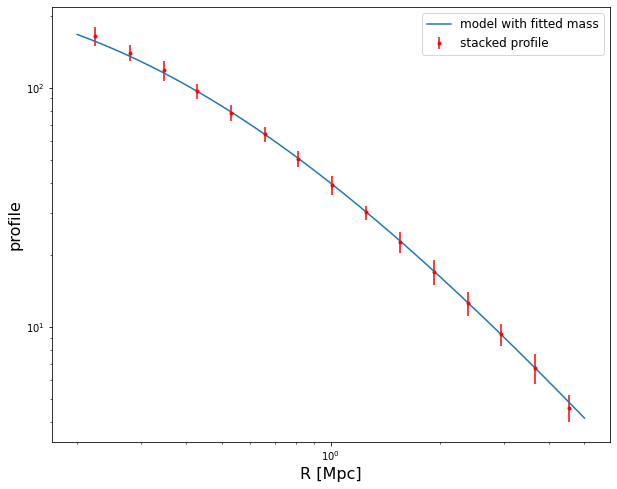

In [34]:
plt.figure(figsize=(10,8))
plt.errorbar(profile['radius'], profile['gt'],profile['gt_err'], color='red', label='stacked profile', fmt='.')
plt.plot(r,y_fit, label='model with fitted mass')
plt.xlabel('R [Mpc]', fontsize=16)
plt.ylabel('profile', fontsize=16)
plt.legend(fontsize=12)
plt.semilogx()
plt.semilogy()